In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

%matplotlib inline

In [2]:
#Get list of active players
players_df=pd.read_html('https://www.basketball-reference.com/leagues/NBA_2022_per_game.html')[0]
players_df=players_df[players_df['Player']!='Player']
players_df=players_df.iloc[:,1:5]
players_df.set_index('Player',inplace=True)
players_df.head(5)

,Pos,Age,Tm
Player,,,
Precious Achiuwa,C,22,TOR
Steven Adams,C,28,MEM
Bam Adebayo,C,24,MIA
Santi Aldama,PF,21,MEM
LaMarcus Aldridge,C,36,BRK


In [3]:
#Get links for all active players to be used in querying
urls = 'https://www.basketball-reference.com/leagues/NBA_2022_per_game.html'
grab = requests.get(urls)
soup = BeautifulSoup(grab.text, 'html.parser')
soup=soup.find('table')

links=[]

for link in soup.find_all("a"):
    data = link.get('href')
    if data[:9] =='/players/'and data[-5:]=='.html':
        url='https://www.basketball-reference.com'+data
        links.append(url)

players_df['Link']=links

In [4]:
print('Unique links: ',players_df['Link'].nunique())
print('Unique Players: ',players_df.index.nunique())

Unique links:  605
Unique Players:  605


In [5]:
#Getting unique list of players to be used in dash
unique_players=players_df.index.sort_values().unique().tolist()
unique_players

['Aaron Gordon',
 'Aaron Henry',
 'Aaron Holiday',
 'Aaron Nesmith',
 'Aaron Wiggins',
 'Abdel Nader',
 'Ade Murkey',
 'Admiral Schofield',
 'Ahmad Caver',
 'Al Horford',
 'Alec Burks',
 'Aleem Ford',
 'Aleksej Pokusevski',
 'Alex Caruso',
 'Alex Len',
 'Alfonzo McKinnie',
 'Alize Johnson',
 'Alperen Şengün',
 'Amir Coffey',
 'Andre Drummond',
 'Andre Iguodala',
 'Andrew Wiggins',
 'Anfernee Simons',
 'Anthony Davis',
 'Anthony Edwards',
 'Anthony Gill',
 'Anthony Lamb',
 'Armoni Brooks',
 'Arnoldas Kulboka',
 'Austin Reaves',
 'Austin Rivers',
 'Avery Bradley',
 'Ayo Dosunmu',
 'B.J. Johnson',
 'Bam Adebayo',
 'Ben McLemore',
 'Bismack Biyombo',
 'Blake Griffin',
 'Boban Marjanović',
 'Bobby Portis',
 'Bogdan Bogdanović',
 'Bojan Bogdanović',
 'Bol Bol',
 'Bones Hyland',
 'Brad Wanamaker',
 'Bradley Beal',
 'Brandon Boston Jr.',
 'Brandon Clarke',
 'Brandon Goodwin',
 'Brandon Ingram',
 'Brandon Knight',
 'Brandon Williams',
 'Braxton Key',
 'Brodric Thomas',
 'Brook Lopez',
 'Bruce B

In [6]:
#Getting unique teamns to be used in Dash
unique_teams=players_df[(players_df['Tm']!='TOT') & (players_df['Tm']!='Tm')]['Tm'].sort_values().unique().tolist()
unique_teams

['ATL',
 'BOS',
 'BRK',
 'CHI',
 'CHO',
 'CLE',
 'DAL',
 'DEN',
 'DET',
 'GSW',
 'HOU',
 'IND',
 'LAC',
 'LAL',
 'MEM',
 'MIA',
 'MIL',
 'MIN',
 'NOP',
 'NYK',
 'OKC',
 'ORL',
 'PHI',
 'PHO',
 'POR',
 'SAC',
 'SAS',
 'TOR',
 'UTA',
 'WAS']

In [7]:
#Adding 'All' to players list so all players including those not in rosters can be queried
unique_teams.insert(0,'ALL')
unique_teams

['ALL',
 'ATL',
 'BOS',
 'BRK',
 'CHI',
 'CHO',
 'CLE',
 'DAL',
 'DEN',
 'DET',
 'GSW',
 'HOU',
 'IND',
 'LAC',
 'LAL',
 'MEM',
 'MIA',
 'MIL',
 'MIN',
 'NOP',
 'NYK',
 'OKC',
 'ORL',
 'PHI',
 'PHO',
 'POR',
 'SAC',
 'SAS',
 'TOR',
 'UTA',
 'WAS']

In [8]:
#Creating player class to inherit attributes and functions
player_queries_standard=[]
player_queries_advanced=[]

reports_dict={'Standard':['div_per_game',player_queries_standard],
     'Advanced':['div_advanced',player_queries_advanced]} 

class Player:
    
    def __init__(self,name):
        self.name=name
        global player_queries_standard
        global player_queries_advanced
        if len(player_queries_standard)==0:
            player_queries_standard=[self.get_per_game('Standard')]
            player_queries_advanced=[self.get_per_game('Advanced')]
        elif name not in pd.concat(player_queries_standard,axis=0)['Player Name'].to_list():
            player_queries_standard.append(self.get_per_game('Standard'))
            player_queries_advanced.append(self.get_per_game('Advanced'))
            reports_dict['Standard'][1]=player_queries_standard
            reports_dict['Advanced'][1]=player_queries_advanced

        
    def __str__(self):
        name=self.name
        pos=self.get_position()
        age=self.get_age()
        tm=self.get_team()
        
        return "Player: {}, Position: {}, Age: {}, Most Recent Team: {}".format(name,pos,age,tm)
    
    def get_info(self,field):
        global player_queries_standard
        queries=pd.concat(player_queries_standard,axis=0)
        df=queries[queries['Player Name']==self.name]
        
        most_recent=df[df['Season']=='Career'].index.to_numpy().sum()-1
        
        return df.loc[most_recent][field]
    
    def get_player_url(self):
        val=players_df.loc[self.name]['Link']
        
        if type(val) is str:
            return val
        else:
            return val[0]
    
    def get_age(self):
        return self.get_info('Age')
    
    def get_position(self):
        return self.get_info('Pos')
    
    def get_team(self):
        return self.get_info('Tm')
    
    def get_per_game(self,report_type):
        req=requests.get(self.get_player_url()).text
        soup=BeautifulSoup(req,'html.parser')
        soup=soup.find(id=reports_dict[report_type][0])
        table=soup.find_all('table')
        df = pd.read_html(str(table))[0]
        df['Player Name']=self.name
        return df
    
    def get_formatted_per_game(self,report_type):
        global player_queries_standard
        global player_queries_advanced
        
        df=pd.concat(reports_dict[report_type][1],axis=0)
        df=df[df['Player Name']==self.name]
        
        df=df.dropna(axis=1, how='all')
        
        #Getting rid of overseas data
        df=df[df['Lg']=='NBA']
        
        #Ensuring only seasons being included in dataframe
        df=df[df['Season'].apply(lambda x: True if "-" in str(x)
                      else False)]
        
        #Ensuring that all player data per season is consolidated into one row (no splits across teams)
        multi_team_df=df.copy().groupby('Season').count()['Tm']
        df=df[df.apply(lambda x: True if int(multi_team_df.loc[x['Season']])==1 or x['Tm']=='TOT'
              else False
            ,axis=1)]
        
        return df
    
    def chart_per_game(self,report_type,field):
        df=self.get_formatted_per_game(report_type)[['Age',field]]
        df[field]=df[field].apply(lambda x: float(x))
        min_age=df['Age'].min()-1
        max_age=df['Age'].max()+2
        plt.figure(figsize=(15,8))
        sns.set_style("whitegrid")
        sns.set_palette('coolwarm')
        sns.regplot(x='Age',y=field,data=df)

        plt.title(str(self))

        plt.xlim(min_age,max_age)
        plt.xticks(np.arange(min_age, max_age, 2))
        plt.title(str(p1))

In [9]:
p1=Player('LeBron James')
p2=Player('Greg Monroe')
p3=Player('Dwight Howard')
p4=Player('Khris Middleton')
p5=Player('Santi Aldama')
p6=Player('RJ Barrett')

In [10]:
print(p1)
print(p2)
print(p3)
print(p4)
print(p5)

Player: LeBron James, Position: PF, Age: 38.0, Most Recent Team: LAL
Player: Greg Monroe, Position: C, Age: 31.0, Most Recent Team: UTA
Player: Dwight Howard, Position: C, Age: 36.0, Most Recent Team: LAL
Player: Khris Middleton, Position: SF, Age: 31.0, Most Recent Team: MIL
Player: Santi Aldama, Position: PF, Age: 22.0, Most Recent Team: MEM


In [11]:
p1.get_formatted_per_game('Standard')

,Season,Age,Tm,Lg,Pos,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player Name
0,2003-04,19.0,CLE,NBA,SG,79.0,79.0,39.5,7.9,18.9,...,1.3,4.2,5.5,5.9,1.6,0.7,3.5,1.9,20.9,LeBron James
1,2004-05,20.0,CLE,NBA,SF,80.0,80.0,42.4,9.9,21.1,...,1.4,6.0,7.4,7.2,2.2,0.7,3.3,1.8,27.2,LeBron James
2,2005-06,21.0,CLE,NBA,SF,79.0,79.0,42.5,11.1,23.1,...,0.9,6.1,7.0,6.6,1.6,0.8,3.3,2.3,31.4,LeBron James
3,2006-07,22.0,CLE,NBA,SF,78.0,78.0,40.9,9.9,20.8,...,1.1,5.7,6.7,6.0,1.6,0.7,3.2,2.2,27.3,LeBron James
4,2007-08,23.0,CLE,NBA,SF,75.0,74.0,40.4,10.6,21.9,...,1.8,6.1,7.9,7.2,1.8,1.1,3.4,2.2,30.0,LeBron James
5,2008-09,24.0,CLE,NBA,SF,81.0,81.0,37.7,9.7,19.9,...,1.3,6.3,7.6,7.2,1.7,1.1,3.0,1.7,28.4,LeBron James
6,2009-10,25.0,CLE,NBA,SF,76.0,76.0,39.0,10.1,20.1,...,0.9,6.4,7.3,8.6,1.6,1.0,3.4,1.6,29.7,LeBron James
7,2010-11,26.0,MIA,NBA,SF,79.0,79.0,38.8,9.6,18.8,...,1.0,6.5,7.5,7.0,1.6,0.6,3.6,2.1,26.7,LeBron James
8,2011-12,27.0,MIA,NBA,SF,62.0,62.0,37.5,10.0,18.9,...,1.5,6.4,7.9,6.2,1.9,0.8,3.4,1.5,27.1,LeBron James
9,2012-13,28.0,MIA,NBA,PF,76.0,76.0,37.9,10.1,17.8,...,1.3,6.8,8.0,7.3,1.7,0.9,3.0,1.4,26.8,LeBron James


In [12]:
p1.get_formatted_per_game('Advanced')

,Season,Age,Tm,Lg,Pos,G,MP,PER,TS%,3PAr,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Player Name
0,2003-04,19.0,CLE,NBA,SG,79.0,3122.0,18.3,0.488,0.145,...,28.2,2.4,2.6,5.1,0.078,2.3,-0.6,1.7,2.9,LeBron James
1,2004-05,20.0,CLE,NBA,SF,80.0,3388.0,25.7,0.554,0.183,...,29.7,9.7,4.6,14.3,0.203,7.0,1.7,8.6,9.1,LeBron James
2,2005-06,21.0,CLE,NBA,SF,79.0,3361.0,28.1,0.568,0.208,...,33.6,12.0,4.3,16.3,0.232,7.5,1.6,9.1,9.4,LeBron James
3,2006-07,22.0,CLE,NBA,SF,78.0,3190.0,24.5,0.552,0.191,...,31.0,8.0,5.7,13.7,0.206,5.9,2.2,8.1,8.1,LeBron James
4,2007-08,23.0,CLE,NBA,SF,75.0,3027.0,29.1,0.568,0.219,...,33.5,10.7,4.6,15.2,0.242,8.2,2.6,10.9,9.8,LeBron James
5,2008-09,24.0,CLE,NBA,SF,81.0,3054.0,31.7,0.591,0.238,...,33.8,13.7,6.5,20.3,0.318,9.5,3.7,13.2,11.8,LeBron James
6,2009-10,25.0,CLE,NBA,SF,76.0,2966.0,31.1,0.604,0.253,...,33.5,13.3,5.2,18.5,0.299,9.1,2.8,11.8,10.3,LeBron James
7,2010-11,26.0,MIA,NBA,SF,79.0,3063.0,27.3,0.594,0.188,...,31.5,10.3,5.3,15.6,0.244,6.3,1.8,8.1,7.8,LeBron James
8,2011-12,27.0,MIA,NBA,SF,62.0,2326.0,30.7,0.605,0.127,...,32.0,10.0,4.5,14.5,0.298,8.2,2.7,10.9,7.6,LeBron James
9,2012-13,28.0,MIA,NBA,PF,76.0,2877.0,31.6,0.640,0.188,...,30.2,14.6,4.7,19.3,0.322,9.3,2.4,11.7,9.9,LeBron James


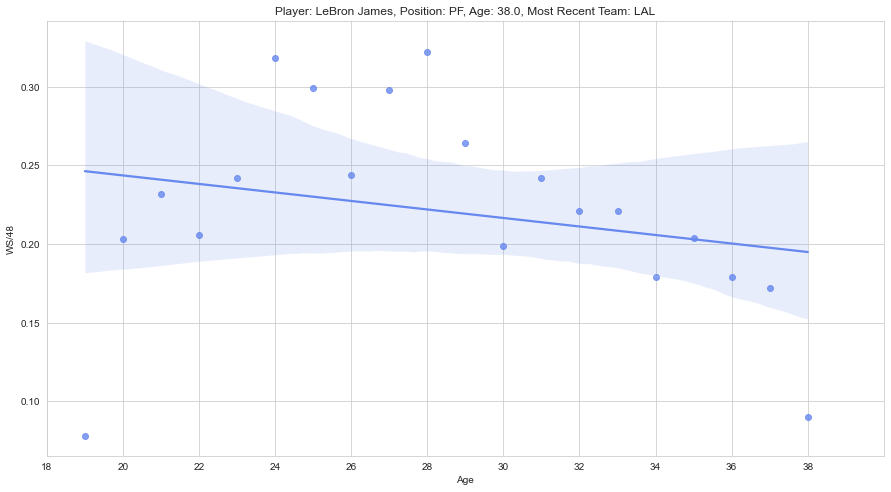

In [13]:
p1.chart_per_game('Advanced','WS/48')

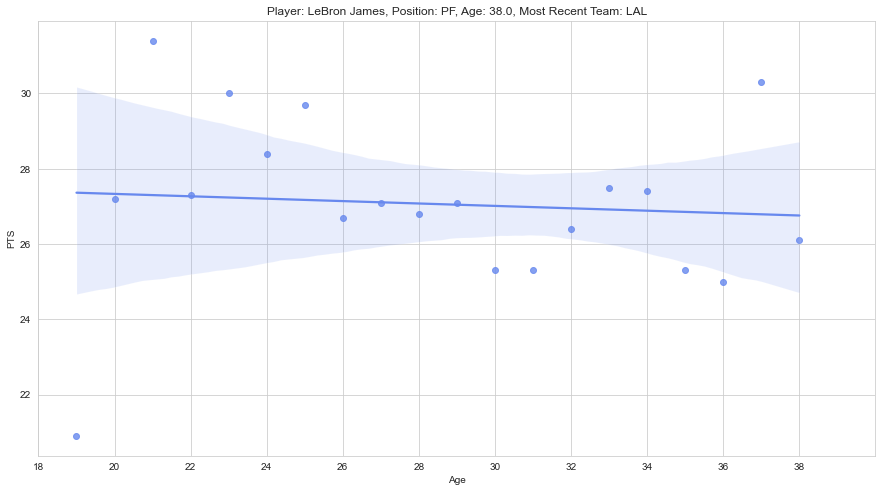

In [14]:
p1.chart_per_game('Standard','PTS')

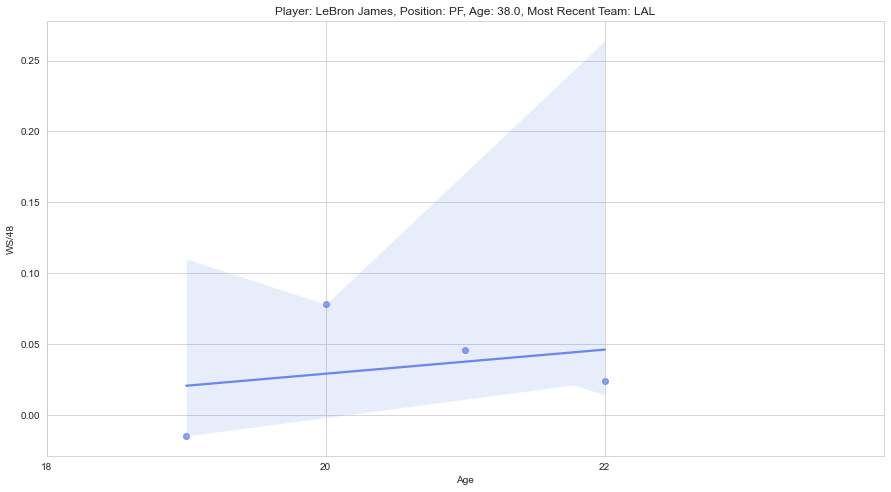

In [15]:
p6.chart_per_game('Advanced','WS/48')

In [16]:
rosters_df=[]
class Team():
    def __init__(self,name):
        global rosters_df
        self.name=name
        self.url='https://www.basketball-reference.com/teams/'+name+'/2023.html'
        if len(rosters_df)==0:
            rosters_df=self.get_rosters()
        elif name not in rosters_df['Tm'].tolist():
            this_roster=self.get_rosters()
            rosters_df=pd.concat([rosters_df,this_roster],axis=0)
            
    def get_rosters(self):
        req=requests.get(self.url).text
        soup=BeautifulSoup(req,'html.parser')
        soup=soup.find(id='div_roster')
        table=soup.find_all('table')
        df = pd.read_html(str(table))[0]
        df['Player']=df['Player'].apply(lambda x: x.replace(' (TW)',''))
        df['Tm']=self.name
        df['Link']=self.get_player_links()
        return df
    
    def get_roster(self):
        return rosters_df[rosters_df['Tm']==self.name]
    
    def get_player_links(self):
        grab = requests.get(self.url)
        soup = BeautifulSoup(grab.text, 'html.parser')
        soup=soup.find('table')

        links=[]

        for link in soup.find_all("a"):
            data = link.get('href')
            if data[:9] =='/players/'and data[-5:]=='.html':
                url='https://www.basketball-reference.com'+data
                links.append(url)
        return links


In [17]:
t1=Team('NYK')
t2=Team('BRK')

In [18]:
t1.get_roster()

,No.,Player,Pos,Ht,Wt,Birth Date,Unnamed: 6,Exp,College,Tm,Link
0,30.0,Julius Randle,PF,6-8,250,"November 29, 1994",us,8,Kentucky,NYK,https://www.basketball-reference.com/players/r...
1,11.0,Jalen Brunson,PG,6-1,190,"August 31, 1996",us,4,Villanova,NYK,https://www.basketball-reference.com/players/b...
2,9.0,RJ Barrett,SG,6-6,214,"June 14, 2000",ca,3,Duke,NYK,https://www.basketball-reference.com/players/b...
3,5.0,Immanuel Quickley,PG,6-3,190,"June 17, 1999",us,2,Kentucky,NYK,https://www.basketball-reference.com/players/q...
4,1.0,Obi Toppin,PF,6-9,220,"March 4, 1998",us,2,Dayton,NYK,https://www.basketball-reference.com/players/t...
5,55.0,Isaiah Hartenstein,C,7-0,250,"May 5, 1998",us,4,NaN,NYK,https://www.basketball-reference.com/players/h...
6,4.0,Derrick Rose,PG,6-3,200,"October 4, 1988",us,13,Memphis,NYK,https://www.basketball-reference.com/players/r...
7,0.0,Cam Reddish,SF,6-8,218,"September 1, 1999",us,3,Duke,NYK,https://www.basketball-reference.com/players/r...
8,23.0,Mitchell Robinson,C,7-0,240,"April 1, 1998",us,4,Western Kentucky,NYK,https://www.basketball-reference.com/players/r...
9,45.0,Jericho Sims,C,6-10,245,"October 20, 1998",us,1,Texas,NYK,https://www.basketball-reference.com/players/s...
